# Create grid
- Get boundary of the city in from OSM
- Find the administrative output areas within that boundary
- Create centroids 

OLD CODE: 
- Create a grid based on the smallest administrative output area
- Add centroids



In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import shapely.wkb
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# User settings
place_name = "Grand Paris Metropolis"
crs_fr = 2154 
#crs_fr = 4326

plt.rcParams['figure.figsize'] = (8, 8)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/osmnx/projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from Py

## Find administrative output area within boundary
- get boundary
- get shapes of the administrative output areas
- subset the areas for those within the boundary

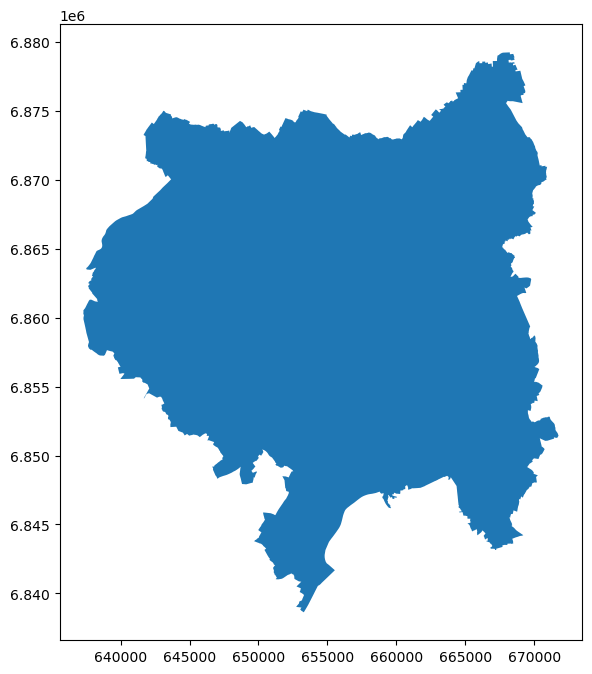

In [2]:
### Get boundary from OSM
GPM = ox.geocode_to_gdf(place_name)
GPM = GPM.to_crs(crs_fr)
GPM.plot()
GPM.to_file('data/raw/GPM_geometry/GPM.geojson', driver = 'GeoJSON')

In [3]:
GPM

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((637298.022 6860280.848, 637298.584 6...",49.012332,48.646162,2.615768,2.145707,308326646,relation,5814660,48.829224,2.366974,"Grand Paris Metropolis, Val-de-Marne, Ile-de-F...",boundary,local_authority,0.755627


<Axes: >

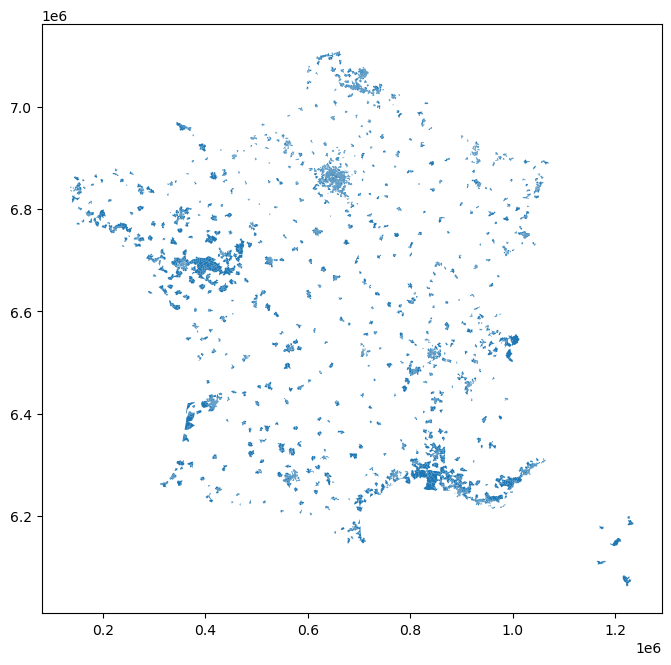

In [4]:
### Get all IRIS shapes in France
IRIS_fr = gpd.read_file("CONTOURS-IRIS_2-1__SHP__FRA_2019-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2019/CONTOURS-IRIS.shp")
IRIS_fr = IRIS_fr.to_crs(crs_fr)
IRIS_fr_habitat = IRIS_fr[IRIS_fr['TYP_IRIS'] == 'H']
IRIS_fr_habitat.plot()

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

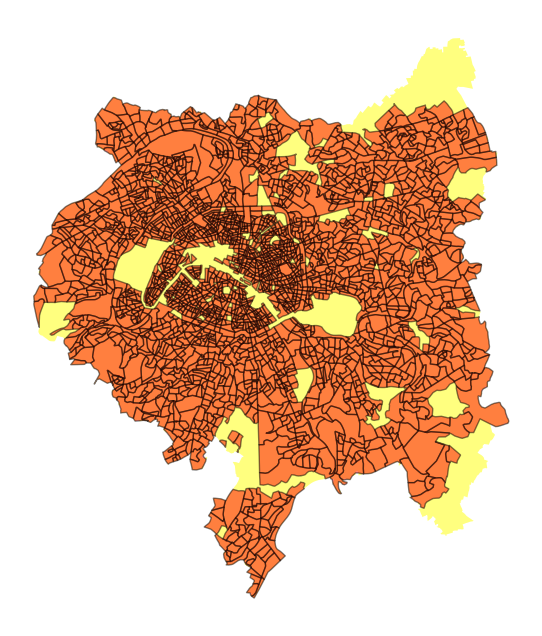

In [5]:
### Find IRIS within GPM

# Find centroids and define them as the geometry
IRIS_fr_habitat['representative_point'] = IRIS_fr_habitat.representative_point()
IRIS_fr_habitat = IRIS_fr_habitat.set_geometry('representative_point')

# Find polygons whose representative points fall within GPM
IRIS_GPM = gpd.sjoin(IRIS_fr_habitat, GPM, how= 'inner')
IRIS_GPM = IRIS_GPM.set_geometry('geometry').drop(columns = 'representative_point')

ax = plt.axes()
ax.axis('off')
GPM.plot(ax=ax, alpha = 0.5, facecolor = 'yellow')
IRIS_GPM.plot(ax=ax, alpha = 0.5, facecolor = 'red', edgecolor ='black')


In [6]:
IRIS_GPM = IRIS_GPM.drop(columns = ['index_right',  
                                    'osm_type', 
                                    'type', 
                                    'bbox_west', 
                                    'bbox_south', 
                                    'bbox_east', 
                                    'bbox_north', 
                                    'TYP_IRIS', 
                                    'display_name',
                                    'IRIS',
                                    'INSEE_COM',
                                    'place_id',
                                    'class',
                                    'importance',
                                    'lat',
                                    'lon',
                                    'NOM_COM',
                                    'NOM_IRIS',
                                    'osm_id'])

In [7]:
IRIS_GPM

,CODE_IRIS,geometry
36,920440109,"POLYGON ((648055.600 6866209.000, 648025.400 6..."
57,930270105,"POLYGON ((656803.300 6869116.600, 656753.200 6..."
77,751197316,"POLYGON ((653970.600 6865885.100, 653973.100 6..."
82,751176716,"POLYGON ((649189.300 6865537.300, 649147.300 6..."
110,920020104,"POLYGON ((649517.800 6851423.900, 649342.800 6..."
...,...,...
48548,930290203,"POLYGON ((660187.500 6869987.000, 660247.100 6..."
48573,920070111,"POLYGON ((649305.700 6855128.700, 649259.800 6..."
48578,930050101,"POLYGON ((662535.900 6871566.500, 662351.800 6..."
48582,920190113,"POLYGON ((647124.400 6852521.300, 647116.000 6..."


In [8]:
IRIS_GPM.CODE_IRIS = IRIS_GPM.CODE_IRIS.astype('string')
IRIS_GPM = IRIS_GPM.reset_index(drop = True)

IRIS_GPM.to_file('data/raw/IRIS_GPM.geojson', driver = 'GeoJSON')


IRIS_GPM = pd.DataFrame(IRIS_GPM)
IRIS_GPM.to_csv('data/processed/IRIS_GPM.csv', index = False)

## Create grid (OLD CODE, NOT USED IN THE END)
- find smallest administrative output area
- Create a grid with that cell size 
- Add centroids

In [9]:
### Get the GPM IRIS
IRIS_GPM = gpd.read_file('data/processed/GPM_IRIS.geojson').drop(columns = ['index_right',  
                                                                            'osm_type', 
                                                                            'type', 
                                                                            'bbox_west', 
                                                                            'bbox_south', 
                                                                            'bbox_east', 
                                                                            'bbox_north', 
                                                                            'TYP_IRIS', 
                                                                            'display_name',
                                                                            'IRIS',
                                                                            'INSEE_COM',
                                                                            'place_id',
                                                                            'class',
                                                                            'importance',
                                                                            'osm_id',
                                                                            'lat',
                                                                            'lon'])
IRIS_GPM.head(2)

,NOM_COM,CODE_IRIS,NOM_IRIS,geometry
0,Paris 11e Arrondissement,751114113,Folie Méricourt 13,"POLYGON ((654130.100 6863650.800, 654171.300 6..."
1,Levallois-Perret,920440109,Wilson-Rivay 1,"POLYGON ((648086.800 6866229.600, 648055.600 6..."


In [10]:
### Find smallest administrative output area (surface-wise)

IRIS_GPM['area'] = IRIS_GPM.area
IRIS_GPM = IRIS_GPM.sort_values(by='area').reset_index(drop = True)
smallest_IRIS_GPM = IRIS_GPM.head(1)
smallest_IRIS_GPM

,NOM_COM,CODE_IRIS,NOM_IRIS,geometry,area
0,Paris 4e Arrondissement,751041305,Saint-Merri 5,"POLYGON ((652530.100 6862186.900, 652619.400 6...",8739.53


In [11]:
### Create grid with cell size = smallest output area 

# bounds of the smallest IRIS 
XMIN, YMIN, XMAX, YMAX = smallest_IRIS_GPM.total_bounds

# bounds of the whole grid
xmin, ymin, xmax, ymax= IRIS_GPM.total_bounds

# cell size in x and y direction 
cell_size_x = int((xmax-xmin)/(XMAX-XMIN))
cell_size_y = int((ymax-ymin)/(YMAX-YMIN))

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size_x, cell_size_x ):
    for y0 in np.arange(ymin, ymax+cell_size_y, cell_size_y):
        # bounds
        x1 = x0-cell_size_x
        y1 = y0+cell_size_y
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))  

# create complete grid and add centroids
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs_fr)
grid['centroid'] = grid.centroid 

<Axes: >

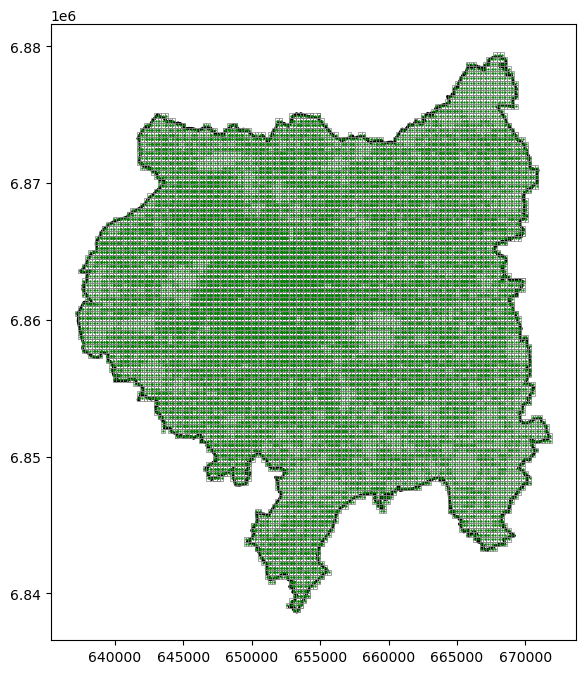

In [12]:
#only keep grid within boundary
grid_GPM = gpd.sjoin(grid, IRIS_GPM, how= 'inner')

# plot 
ax = plt.axes()
GPM.plot(ax=ax, facecolor = 'none', edgecolor = 'black', linewidth = 2)
grid_GPM.plot(ax=ax, facecolor="none", edgecolor='grey', linewidth = 0.5)
grid_GPM['centroid'].plot(ax=ax, markersize=0.5, facecolor = 'green')

In [13]:
### Save as csv to allow for both the grid and the centroids (= geometries) to be saved 

# Reproject stuff
grid_GPM_reproject = grid_GPM.to_crs(4326).drop(columns = ['centroid','area', 'index_right']) #for the polygons
grid_GPM_reproject['centroid'] = grid_GPM_reproject.centroid #recalculate centroids
grid_GPM_reproject #
grid_centroids_IRIS_GPM = pd.DataFrame(grid_GPM_reproject)
grid_centroids_IRIS_GPM.to_csv('data/processed/GPM_grid.csv', index = False)

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_21309/3517152703.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_GPM_reproject['centroid'] = grid_GPM_reproject.centroid #recalculate centroids


In [14]:
# ### code snippet on how to use the csv later on

# grid_centroids = pd.read_csv('data/processed/GPM_grid.csv')

# for c in ['geometry', 'centroid']:
#     test[c] = test[c].apply(shapely.wkt.loads)

# grid_centroids = gpd.GeoDataFrame(grid_centroids, crs = crs_fr, geometry= 'geometry' )

# ax = plt.axes()

# grid_centroids.plot(ax=ax, facecolor="none", edgecolor='grey', linewidth = 0.1)
# grid_centroids.centroid.plot(ax=ax, markersize=1, facecolor = 'green')

In [15]:
# ### Connecting stuff


# """
# H = car network (networkX graph, nodes and edges)
# banw = bike network (networkX graph, nodes and edges)
# grid_centroids = grid with centroids (GeoDataFrame, geometries for cells and for centroids)

# thoughts:
# - turn the centroids into a completely disconnected network of nodes DONE
# - make the nodes have the necessary info to connect them back to IRIS (but not more!) DONE? 
# - then see how to connect them to their closest neighbor in banw or H (R5R?)
# """

# # only use centroids
# centroid_nodes = grid_centroids[['centroid', 'CODE_IRIS']].set_geometry('centroid')

# # separate coordinates for x and y 
# centroid_nodes['x'] = centroid_nodes['centroid'].x
# centroid_nodes['y'] = centroid_nodes['centroid'].y

# # Create a dictionary of attributes 
# centroid_nodes["attr_dict"] = centroid_nodes.apply(lambda k: make_attr_dict(x = k.x, y = k.y, code_iris = k.CODE_IRIS), axis = 1) # add attr_dict
# centroid_nodes['num'] = centroid_nodes.index

# # Turn the centroids into nodes of a graph
# grid = nx.Graph()
# grid.add_nodes_from(centroid_nodes.loc[:,["num", "attr_dict"]].itertuples(index = False))